# Problem 1 - Yield curve

In [35]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt

In [36]:
iv_swaption_market = np.array([0.275616, 0.237815, 0.209661, 0.183214, 0.163977, 0.140387, 0.132907, 0.124768, 0.12871, 0.134726, 0.145571, 0.149179, 0.160561])
K_swaption_offset = np.array([-300,-250,-200,-150,-100,-50,0,50,100,150,200,250,300])

Euribor_fixing = [{"id": 0,"instrument": "libor","maturity": 1/2, "rate": 0.02869}]
fra_market = [{"id": 1,"instrument": "fra","exercise": 1/12,"maturity": 7/12, "rate": 0.03075},
{"id": 2,"instrument": "fra","exercise": 2/12,"maturity": 8/12, "rate": 0.03273},
{"id": 3,"instrument": "fra","exercise": 3/12,"maturity": 9/12, "rate": 0.03463},
{"id": 4,"instrument": "fra","exercise": 4/12,"maturity": 10/12, "rate": 0.03645},
{"id": 5,"instrument": "fra","exercise": 5/12,"maturity": 11/12, "rate": 0.03820},
{"id": 6,"instrument": "fra","exercise": 6/12,"maturity": 12/12, "rate": 0.03988},
{"id": 7,"instrument": "fra","exercise": 7/12,"maturity": 13/12, "rate": 0.04148},
{"id": 8,"instrument": "fra","exercise": 8/12,"maturity": 14/12, "rate": 0.04302},
{"id": 9,"instrument": "fra","exercise": 9/12,"maturity": 15/12, "rate": 0.04449}]
swap_market = [{"id": 10,"instrument": "swap","maturity": 2, "rate": 0.04329, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 11,"instrument": "swap","maturity": 3, "rate": 0.04936, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 12,"instrument": "swap","maturity": 4, "rate": 0.05349, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 13,"instrument": "swap","maturity": 5, "rate": 0.05622, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 14,"instrument": "swap","maturity": 7, "rate": 0.05898, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 15,"instrument": "swap","maturity": 10, "rate": 0.05966, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 16,"instrument": "swap","maturity": 15, "rate": 0.05797, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 17,"instrument": "swap","maturity": 20, "rate": 0.05599, "float_freq": "semiannual", "fixed_freq": "annual","indices": []},
{"id": 18,"instrument": "swap","maturity": 30, "rate": 0.05334, "float_freq": "semiannual", "fixed_freq": "annual","indices": []}]
data_zcb = Euribor_fixing + fra_market + swap_market

# interpolation_options = {"method":"linear","transition": "smoo"}
interpolation_options = {"method":"hermite","degree":3,"transition": "smooth"}
# interpolation_options = {"method":"nelson_siegel","transition": "smooth"}


In [37]:
# Problem 1a - Fitting a ZCB term structure to the market data.
mesh = 1/12
M = 360
T_fit, R_fit = fid.zcb_curve_fit(data_zcb,interpolation_options = interpolation_options)
T_inter = np.array([i*mesh for i in range(0,M+1)])
p_inter, R_inter, f_inter, T_inter = fid.zcb_curve_interpolate(T_inter,T_fit,R_fit,interpolation_options = interpolation_options)
R_2Y_swap, S_2Y_swap = fid.swap_rate_from_zcb_prices(0,0,2,"annual",T_inter,p_inter)
R_5Y_swap, S_5Y_swap = fid.swap_rate_from_zcb_prices(0,0,5,"annual",T_inter,p_inter)
R_8Y_swap, S_80Y_swap = fid.swap_rate_from_zcb_prices(0,0,8,"annual",T_inter,p_inter)
R_10Y_swap, S_10Y_swap = fid.swap_rate_from_zcb_prices(0,0,10,"annual",T_inter,p_inter)
R_30Y_swap, S_30Y_swap = fid.swap_rate_from_zcb_prices(0,0,30,"annual",T_inter,p_inter)
print(f"1b - R_2Y_swap: {R_2Y_swap}, R_5Y_swap: {R_5Y_swap}, R_8Y_swap: {R_8Y_swap}, R_10Y_swap: {R_10Y_swap}, R_30Y_swap: {R_30Y_swap}")
T_6M = np.array([i*0.5 for i in range(0,61)])
p_6M = np.array(fid.for_values_in_list_find_value_return_value(T_6M,T_inter,p_inter))
L_6M = fid.forward_rates_from_zcb_prices(T_6M,p_6M,horizon = 1)


1b - R_2Y_swap: 0.04329000000012074, R_5Y_swap: 0.05621999999972216, R_8Y_swap: 0.05951664173949415, R_10Y_swap: 0.059659999999815506, R_30Y_swap: 0.05333999999980386


# Problem 2 - Pricing the interest rate cap

In [38]:
# Problem 2
K_6Y_swap, mat_6Y_swap = 100, 6
K_frb, mat_frb, cp_rate_frb = 100, 6, 0.06
K_zcb, mat_zcb = 100, 6
delta_zcb_rates = 0.001
R_6Y_swap, S_6Y_swap = fid.swap_rate_from_zcb_prices(0,0,mat_6Y_swap,"annual",T_inter,p_inter)
print(f"2ai - 6Y swap. R_6Y_swap: {R_6Y_swap}, S_6Y_swap: {S_6Y_swap}")
T_frb = np.array([i for i in range(0,mat_frb+1)])
C_frb = np.zeros(mat_frb + 1)
for i in range(1,mat_frb + 1):
    C_frb[i] = (T_frb[i]-T_frb[i-1])*cp_rate_frb*K_frb
C_frb[-1] += K_frb
p_frb = np.array(fid.for_values_in_list_find_value_return_value(T_frb,T_inter,p_inter))
price_frb = np.matmul(p_frb,C_frb)
ytm_frb = fid.ytm(price_frb,T_frb,C_frb)
D_frb = fid.macauley_duration(price_frb,T_frb,C_frb,ytm_frb)
conv_frb = fid.convexity(price_frb,T_frb,C_frb,ytm_frb)
print(f"2aii - 6Y Fixed rate bond. Price: {price_frb}, YTM: {ytm_frb}, D_frb: {D_frb}, K_frb: {conv_frb}")
p_zcb = fid.for_values_in_list_find_value_return_value(mat_zcb,T_inter,p_inter)
price_zcb = p_zcb*K_zcb
ytm_zcb = (1/p_zcb)**(1/mat_zcb)-1
D_zcb = mat_zcb
conv_zcb = mat_zcb**2
print(f"2aiii - 6Y ZCB. Price: {price_zcb}, YTM: {ytm_zcb}, D_zcb: {D_zcb}, K_zcb: {conv_zcb}")


2ai - 6Y swap. R_6Y_swap: 0.05793853777698048, S_6Y_swap: 5.025105607418494
2aii - 6Y Fixed rate bond. Price: 101.03590653763767, YTM: 0.05790717788133841, D_frb: 5.216971284979533, K_frb: 29.541873563724977
2aiii - 6Y ZCB. Price: 70.88527289312671, YTM: 0.05902772690850133, D_zcb: 6, K_zcb: 36


In [39]:
# Problem 2b
R_inter_shift = R_inter + np.array([delta_zcb_rates for i in range(0,len(R_inter))])
p_inter_shift = fid.zcb_prices_from_spot_rates(R_inter_shift,T_inter)
R_6Y_swap_shift, S_6Y_swap_shift = fid.swap_rate_from_zcb_prices(0,0,mat_6Y_swap,"annual",T_inter,p_inter_shift)
change_6Y_swap_exact = (R_6Y_swap-R_6Y_swap_shift)*S_6Y_swap_shift*K_6Y_swap
print(f"2bi - 6Y swap after shift. R: {R_6Y_swap_shift}, S: {S_6Y_swap_shift}. Exact absolute change using the accrual factor: {change_6Y_swap_exact}")
p_frb_shift = np.array(fid.for_values_in_list_find_value_return_value(T_frb,T_inter,p_inter_shift))
price_frb_shift = np.matmul(p_frb_shift,C_frb)
ytm_frb_shift = fid.ytm(price_frb_shift,T_frb,C_frb)
print(f"2bii - 6Y Fixed rate bond after shift. YTM: {ytm_frb_shift}. Exact absolute change: {price_frb_shift-price_frb}")
p_zcb_shift = fid.for_values_in_list_find_value_return_value(mat_zcb,T_inter,p_inter_shift)
price_zcb_shift = p_zcb_shift*K_zcb
ytm_zcb_shift = (1/p_zcb_shift)**(1/mat_zcb)-1
print(f"2biii - 6Y ZCB after shift. YTM: {ytm_zcb_shift}. Exact absolute change: {price_zcb_shift-price_zcb}")


2bi - 6Y swap after shift. R: 0.05897767157300894, S: 5.008465843009808. Exact absolute change using the accrual factor: -0.5204466123725677
2bii - 6Y Fixed rate bond after shift. YTM: 0.0589621087467403. Exact absolute change: -0.523876836945405
2biii - 6Y ZCB after shift. YTM: 0.06008728432582222. Exact absolute change: -0.4240382504932967


In [40]:
# Problem 2c
idx_shift = np.array([12,24,36,48,60,72])
change_6Y_swap, change_frb, change_zcb = np.zeros(6), np.zeros(6), np.zeros(6)
for i, idx in enumerate(idx_shift):
    R_inter_shift = R_inter.copy()
    R_inter_shift[idx] = R_inter[idx] + delta_zcb_rates
    p_inter_shift = fid.zcb_prices_from_spot_rates(R_inter_shift,T_inter)
    R_6Y_swap_shift, S_6Y_swap_shift = fid.swap_rate_from_zcb_prices(0,0,mat_6Y_swap,"annual",T_inter,p_inter_shift)
    change_6Y_swap[i] = (R_6Y_swap-R_6Y_swap_shift)*S_6Y_swap_shift*K_6Y_swap
    p_frb_shift = np.array(fid.for_values_in_list_find_value_return_value(T_frb,T_inter,p_inter_shift))
    price_frb_shift = np.matmul(p_frb_shift,C_frb)
    change_frb[i] = price_frb_shift-price_frb
    p_zcb_shift = fid.for_values_in_list_find_value_return_value(mat_zcb,T_inter,p_inter_shift)
    price_zcb_shift = p_zcb_shift*K_zcb
    change_zcb[i] = price_zcb_shift-price_zcb
print(f"2ci - 6Y swap. Sensitivities: {np.round(change_6Y_swap,5)}, {sum(change_6Y_swap)}")
print(f"2cii - Fixed rate bond. Sensitivities: {np.round(change_frb,5)}, {sum(change_frb)}")
print(f"2ciii - Zero coupon bond. Sensitivities: {np.round(change_zcb,5)}, {sum(change_zcb)}")


2ci - 6Y swap. Sensitivities: [-0.0056  -0.01063 -0.015   -0.01873 -0.02188 -0.44861], -0.5204466123725866
2cii - Fixed rate bond. Sensitivities: [-0.0058  -0.01101 -0.01553 -0.01939 -0.02266 -0.44948], -0.5238768369453908
2ciii - Zero coupon bond. Sensitivities: [ 0.       0.       0.       0.       0.      -0.42404], -0.4240382504932967


# Problem 3 - Computing the price of the 3Y7Y payer swaption

In [41]:
# Problem 3
strike_cap = 0.07
strike_floor = 0.05
mat_caplet = 10
param_0 = 0.025, 3, 0.1
sigma_vasicek = 0.01
sigma_ho_lee = 0.01
result = minimize(fid.fit_vasicek_sigma_fixed_obj,param_0,method = 'nelder-mead',args = (sigma_vasicek,R_inter,T_inter),options={'xatol': 1e-20,'disp': False})
r0_vasicek, a_vasicek, b_vasicek = result.x
print(f"3ai - Vaseicek parameters: r0: {r0_vasicek}, a: {a_vasicek}, b: {b_vasicek}, sigma: {sigma_vasicek}, SSE: {result.fun}")
R_vasicek = fid.spot_rate_vasicek(r0_vasicek,a_vasicek,b_vasicek,sigma_vasicek,T_inter)
f_fit = np.array(fid.for_values_in_list_find_value_return_value(T_fit,T_inter,f_inter))
mesh_theta, M_theta = 1/1000, 30000
T_star = np.array([i*mesh_theta for i in range(0,M_theta+1)])
f_star, f_T_star = fid.interpolate(T_star,T_inter,f_inter,interpolation_options)
theta = fid.theta_ho_lee(T_star,sigma_ho_lee,method = "default",f_T=f_T_star)

3ai - Vaseicek parameters: r0: 0.01652427956412192, a: 1.9712570366200446, b: 0.11010859601222583, sigma: 0.01, SSE: 0.005049607906685947


In [42]:
# Problem 3b - Simulation
M_simul, T_simul, seed = 1000, 10, 5
mesh_simul = T_simul/M_simul
size_ci = 0.95
r0 = r0_vasicek
t_simul = np.array([i*mesh_simul for i in range(0,M_simul+1)])
mean_vasicek = fid.mean_vasicek(r0,a_vasicek,b_vasicek,sigma_vasicek,t_simul)
lb_vasicek, ub_vasicek = fid.ci_vasicek(r0,a_vasicek,b_vasicek,sigma_vasicek,t_simul,size_ci,type_ci = "two_sided")
np.random.seed(seed)
r_vasicek = fid.simul_vasicek(r0,a_vasicek,b_vasicek,sigma_vasicek,M_simul,T_simul,method = "exact",seed = seed)
f_simul, f_T_simul = fid.interpolate(t_simul,T_fit,f_fit,interpolation_options)
np.random.seed(seed)
r_ho_lee = fid.simul_ho_lee(
    r0_vasicek,
    t_simul,          # ← FIX
    sigma_ho_lee,
    method="exact",
    f=f_simul)         # ← også vigtigt
mean_ho_lee, var_ho_lee = fid.mean_var_ho_lee(f_simul,sigma_ho_lee,t_simul)
lb_ho_lee, ub_ho_lee = fid.ci_ho_lee(f_simul,sigma_ho_lee,t_simul,size_ci,type_ci = "two_sided")


In [46]:
import importlib
importlib.reload(fid)

<module 'fixed_income_derivatives_E2025' from "/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/Fixed_Income_Exam/04_Exams/fixed_income_derivatives_E2025.py">

In [48]:
# Problem 3c - Cap and floor prices
T_caplet = np.array([i*0.5 for i in range(0,int(mat_caplet/0.5)+1)])
p_caplet = np.array(fid.for_values_in_list_find_value_return_value(T_caplet,T_inter,p_inter))
price_caplet_vasicek = fid.caplet_prices_vasicek(sigma_vasicek,strike_cap,a_vasicek,T_caplet,p_caplet)
price_caplet_ho_lee = fid.caplet_prices_ho_lee(sigma_ho_lee,strike_cap,T_caplet,p_caplet)
print(f"3ci - Caplet prices for T = 2,4,6,8,10 in Vasicek: {[np.round(10000*price_caplet_vasicek[4],5),np.round(10000*price_caplet_vasicek[8],5),np.round(10000*price_caplet_vasicek[12],5),np.round(10000*price_caplet_vasicek[16],5),np.round(10000*price_caplet_vasicek[20],5)]}")
print(f"3ci - Caplet prices for T = 2,4,6,8,10 in Ho-Lee: {[np.round(10000*price_caplet_ho_lee[4],5),np.round(10000*price_caplet_ho_lee[8],5),np.round(10000*price_caplet_ho_lee[12],5),np.round(10000*price_caplet_ho_lee[16],5),np.round(10000*price_caplet_ho_lee[20],5)]}")
price_cap_vasicek = sum(price_caplet_vasicek)
price_cap_ho_lee = sum(price_caplet_ho_lee)
print(f"3ca - Cap price Vasicek: {price_cap_vasicek*10000} bps, Cap price Ho-Lee: {price_cap_ho_lee*10000} bps")

def floorlet_prices_vasicek(sigma,strike,a,T,p):
    price_floorlet = np.zeros([len(T)])
    if type(strike) == int or type(strike) == float or type(strike) == np.int32 or type(strike) == np.int64 or type(strike) == np.float64:
        for i in range(2,len(T)):
            price_floorlet[i] = (1 + (T[i]-T[i-1])*strike)*fid.euro_option_price_vasicek(1/(1 + (T[i]-T[i-1])*strike),T[i-1],T[i],p[i-1],p[i],a,sigma,type_option = "call")
    elif type(strike) == tuple or type(strike) == list or type(strike) == np.ndarray:
        for i in range(2,len(T)):
            price_floorlet[i] = (1 + (T[i]-T[i-1])*strike[i])*fid.euro_option_price_vasicek(1/(1 + (T[i]-T[i-1])*strike[i]),T[i-1],T[i],p[i-1],p[i],a,sigma,type_option = "call")
    return price_floorlet

def floorlet_prices_ho_lee(sigma,strike,T,p):
    price_floorlet = np.zeros([len(T)])
    if type(strike) == int or type(strike) == float or type(strike) == np.int32 or type(strike) == np.int64 or type(strike) == np.float64:
        for i in range(2,len(T)):
            price_floorlet[i] = (1 + (T[i]-T[i-1])*strike)*fid.euro_option_price_ho_lee(1/(1 + (T[i]-T[i-1])*strike),T[i-1],T[i],p[i-1],p[i],sigma,type_option = "call")
    elif type(strike) == tuple or type(strike) == list or type(strike) == np.ndarray:
        for i in range(2,len(T)):
            price_floorlet[i] = (1 + (T[i]-T[i-1])*strike[i])*fid.euro_option_price_ho_lee(1/(1 + (T[i]-T[i-1])*strike[i]),T[i-1],T[i],p[i-1],p[i],sigma,type_option = "call")
    return price_floorlet

price_floorlet_vasicek = floorlet_prices_vasicek(sigma_vasicek,strike_floor,a_vasicek,T_caplet,p_caplet)
price_floorlet_ho_lee = floorlet_prices_ho_lee(sigma_ho_lee,strike_floor,T_caplet,p_caplet)
print(f"3ciii - Floorlet prices for T = 1,2,4,6,8,10 in Vasicek: {[np.round(10000*price_floorlet_vasicek[2],5),np.round(10000*price_floorlet_vasicek[4],5),np.round(10000*price_floorlet_vasicek[8],5),np.round(10000*price_floorlet_vasicek[12],5),np.round(10000*price_floorlet_vasicek[16],5),np.round(10000*price_floorlet_vasicek[20],5)]}")
print(f"3ciii - Floorlet prices for T = 1,2,4,6,8,10 in Ho-Lee: {[np.round(10000*price_floorlet_ho_lee[2],5),np.round(10000*price_floorlet_ho_lee[4],5),np.round(10000*price_floorlet_ho_lee[8],5),np.round(10000*price_floorlet_ho_lee[12],5),np.round(10000*price_floorlet_ho_lee[16],5),np.round(10000*price_floorlet_ho_lee[20],5)]}")
price_floor_vasicek = sum(price_floorlet_vasicek)
price_floor_ho_lee = sum(price_floorlet_ho_lee)
print(f"3ciii - Floor price Vasicek: {price_floor_vasicek*10000} bps, Cap price Ho-Lee: {price_floor_ho_lee*10000} bps")

3ci - Caplet prices for T = 2,4,6,8,10 in Vasicek: [np.float64(1e-05), np.float64(1.43273), np.float64(1.09421), np.float64(0.04516), np.float64(0.00038)]
3ci - Caplet prices for T = 2,4,6,8,10 in Ho-Lee: [np.float64(3.38223), np.float64(25.78555), np.float64(29.05696), np.float64(24.86976), np.float64(21.18938)]
3ca - Cap price Vasicek: 10.394502118115662 bps, Cap price Ho-Lee: 389.8391001869511 bps
3ciii - Floorlet prices for T = 1,2,4,6,8,10 in Vasicek: [np.float64(48.91082), np.float64(0.39521), np.float64(0.0), np.float64(0.0), np.float64(0.00016), np.float64(0.01967)]
3ciii - Floorlet prices for T = 1,2,4,6,8,10 in Ho-Lee: [np.float64(50.19115), np.float64(13.21356), np.float64(7.97818), np.float64(12.23255), np.float64(18.85744), np.float64(24.90057)]
3ciii - Floor price Vasicek: 59.59677974442921 bps, Cap price Ho-Lee: 317.1391510865542 bps


In [49]:
# Problem 3d
def floor_vasicek_obj(strike,price_floor,sigma,a,T,p):
    price_floorlet = floorlet_prices_vasicek(sigma,strike[0],a,T,p)
    price_floor_new = sum(price_floorlet)
    sse = (price_floor - price_floor_new)**2
    return sse

def floor_ho_lee_obj(strike,price_floor,sigma,T,p):
    price_floorlet = floorlet_prices_ho_lee(sigma,strike[0],T,p)
    price_floor_new = sum(price_floorlet)
    sse = (price_floor - price_floor_new)**2
    return sse

param_0 = 0.05
result = minimize(floor_vasicek_obj,param_0,method = 'nelder-mead',args = (price_cap_vasicek,sigma_vasicek,a_vasicek,T_caplet,p_caplet),options={'xatol': 1e-20,'disp': False})
strike_floor_vasicek_client = result.x[0]
result = minimize(floor_ho_lee_obj,param_0,method = 'nelder-mead',args = (price_cap_ho_lee,sigma_ho_lee,T_caplet,p_caplet),options={'xatol': 1e-20,'disp': False})
strike_floor_ho_lee_client = result.x[0]
price_floorlet_vasicek_client = floorlet_prices_vasicek(sigma_vasicek,strike_floor_vasicek_client,a_vasicek,T_caplet,p_caplet)
price_floorlet_ho_lee_client = floorlet_prices_ho_lee(sigma_ho_lee,strike_floor_ho_lee_client,T_caplet,p_caplet)
price_floor_vasicek_client = sum(price_floorlet_vasicek_client)
price_floor_ho_lee_client = sum(price_floorlet_ho_lee_client)
print(f"3d - strike_floor_vasicek_client: {strike_floor_vasicek_client}, price_floor_vasicek_client: {10000*price_floor_vasicek_client} bps, strike_floor_ho_lee_client: {strike_floor_ho_lee_client}, price_floor_ho_lee_client: {10000*price_floor_ho_lee_client} bps")


3d - strike_floor_vasicek_client: 0.04142348232260648, price_floor_vasicek_client: 10.394502118115785 bps, strike_floor_ho_lee_client: 0.05285856529260005, price_floor_ho_lee_client: 389.8391001869479 bps


# Problem 4 - Short rate dynamics

4a - ATMF 5Y75 par swap rate: 0.0643875576464261
4b - Parameters from the SABR fit where beta: 0.58 are: sigma_0: 0.03581, upsilon: 0.65415, rho: -0.25319, SSE: 5.8528497267427206e-05
4d - Discount factor used to price the lookback option: 0.7573402631726474
4d - Price of the lookback option: 99.46611598003031


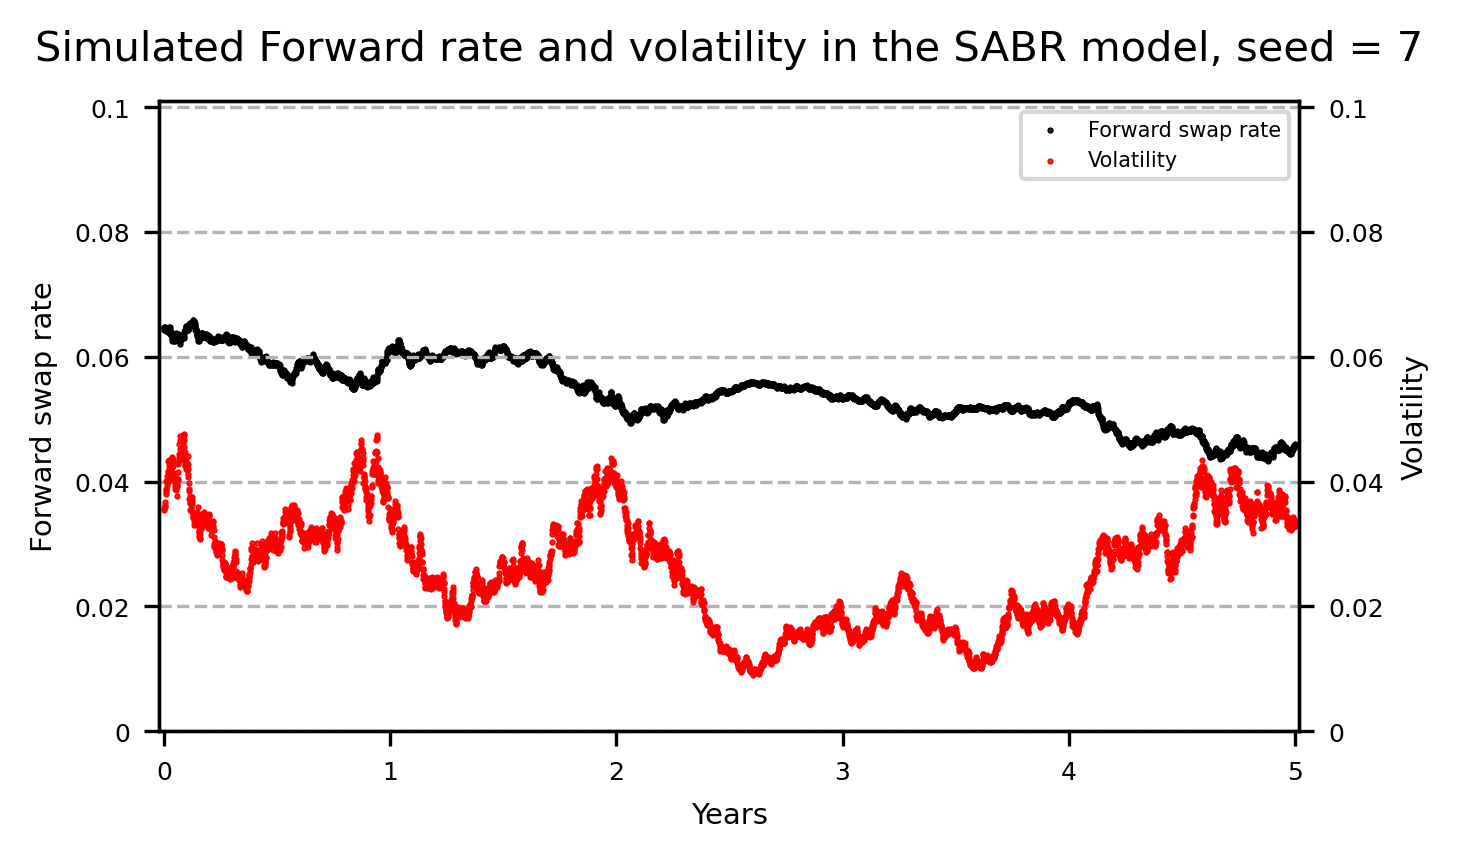

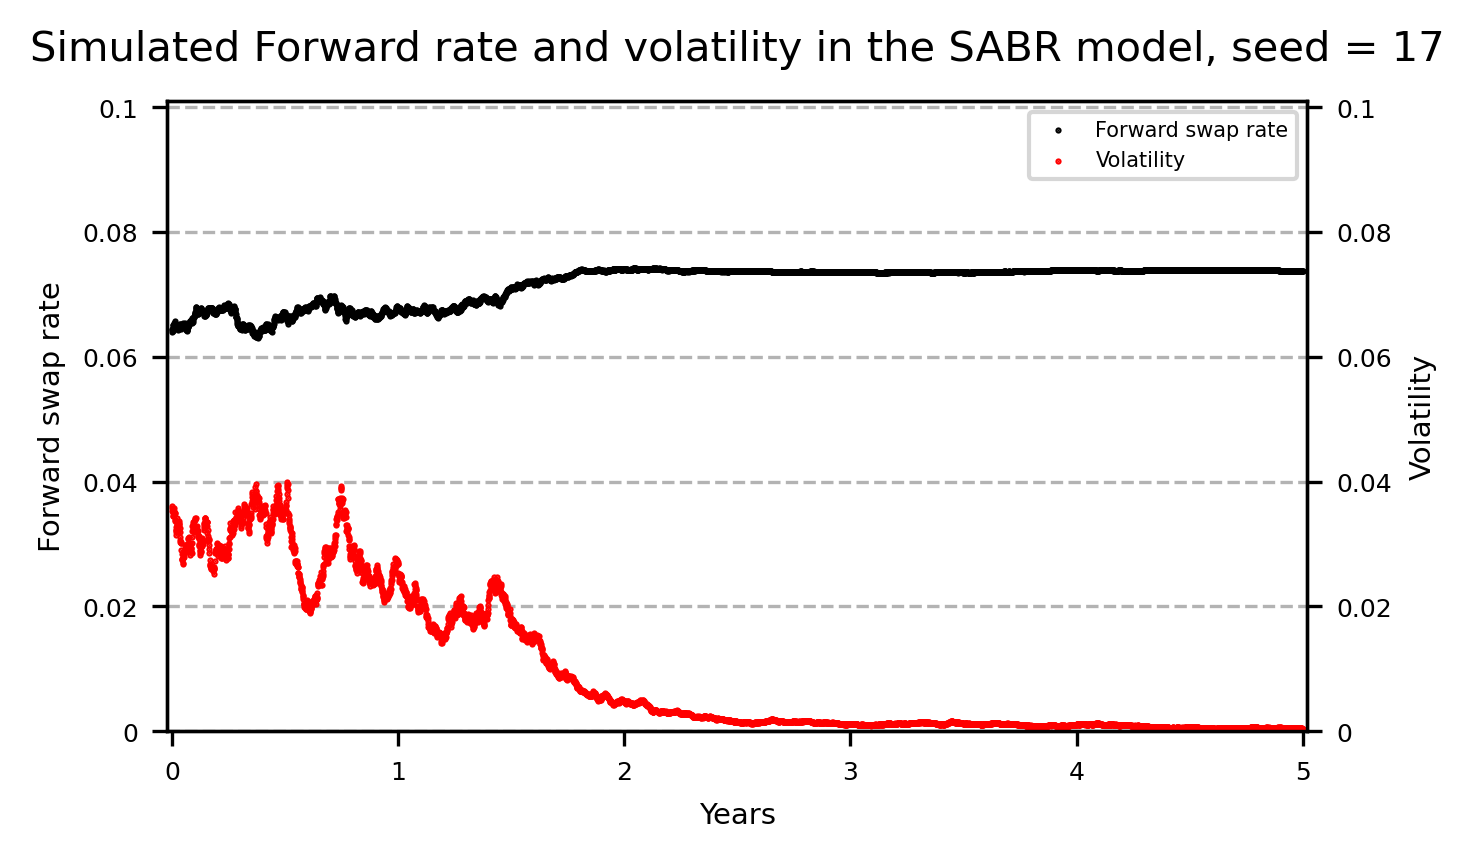

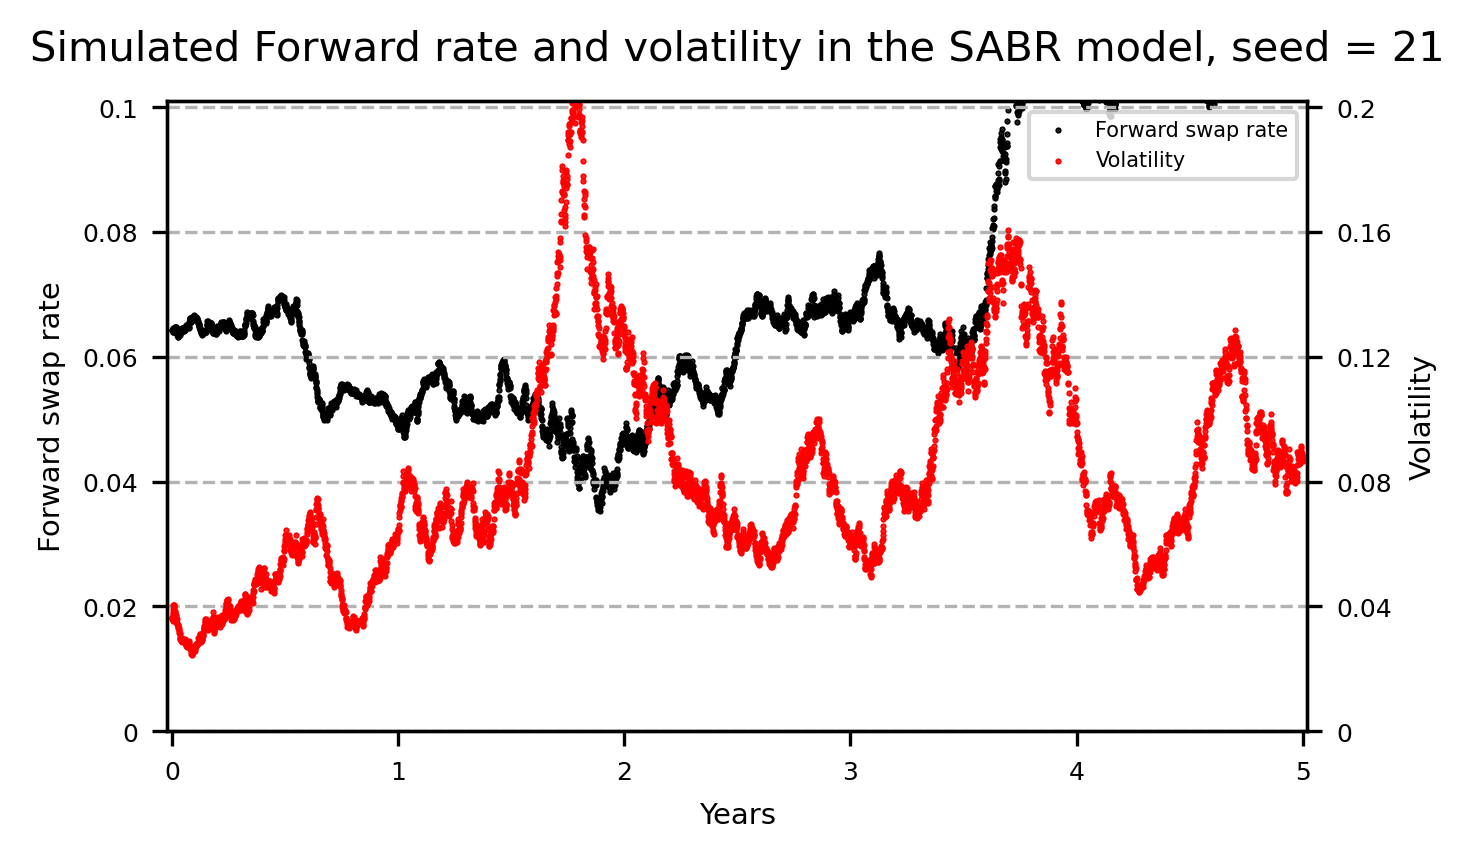

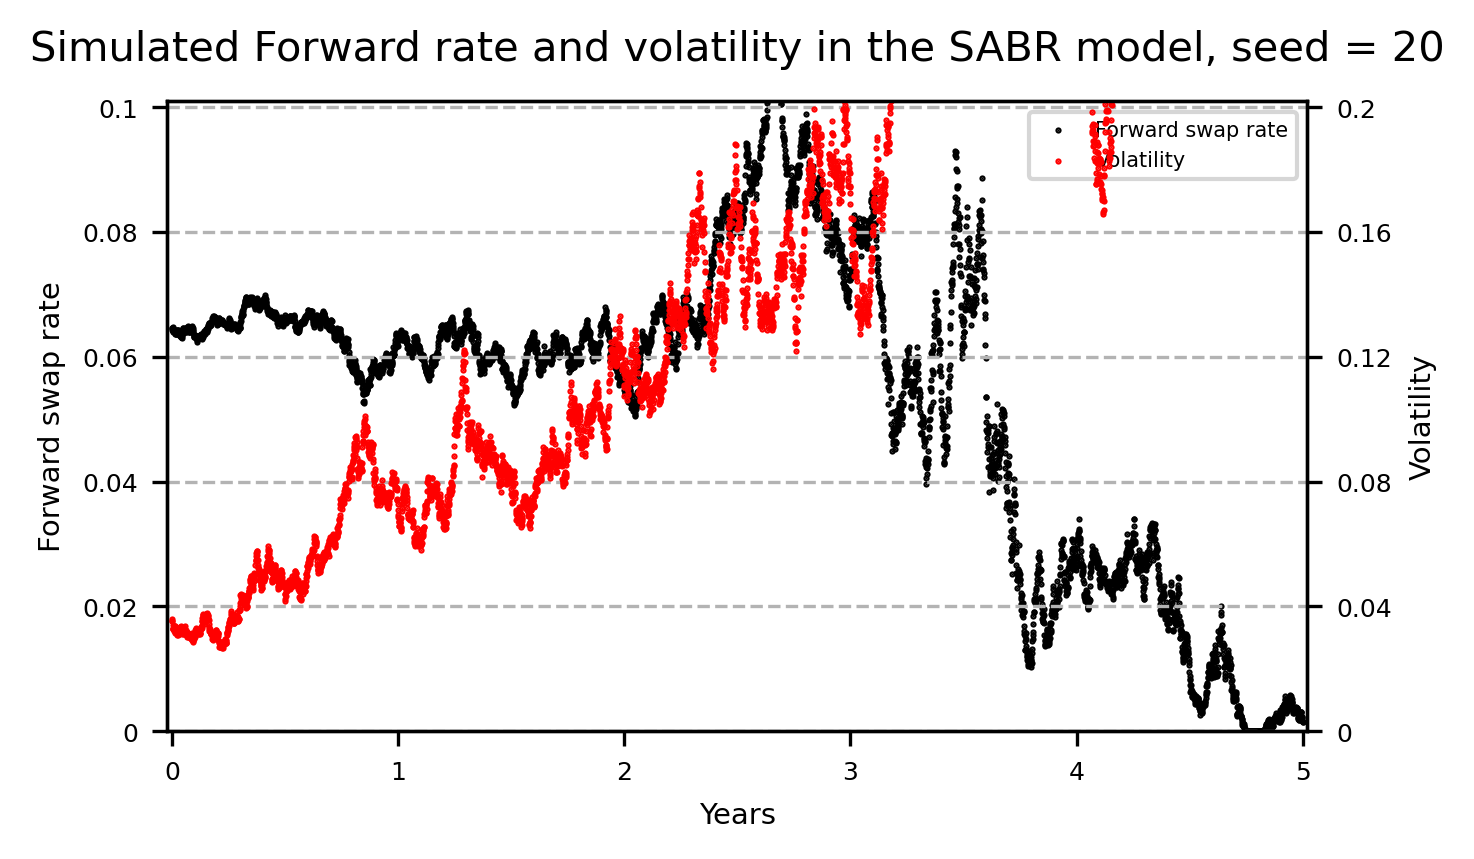

In [50]:
# Problem 4
T_n, T_N = 5, 10
beta = 0.58
param_0 = 0.032, 0.6,-0.20
seed_sabr = 8
R_swaption, S_swaption = fid.swap_rate_from_zcb_prices(0,T_n,T_N,"annual",T_inter,p_inter)
print(f"4a - ATMF 5Y75 par swap rate: {R_swaption}")
N_swaption = len(K_swaption_offset)
K_swaption = K_swaption_offset/10000 + R_swaption*np.ones(N_swaption)
result = minimize(fid.fit_sabr_no_beta_obj,param_0,method = 'nelder-mead',args = (beta,iv_swaption_market,K_swaption,T_n,R_swaption),options={'xatol': 1e-8,'disp': False})
sigma_0, upsilon, rho = result.x
print(f"4b - Parameters from the SABR fit where beta: {np.round(beta,5)} are: sigma_0: {np.round(sigma_0,5)}, upsilon: {np.round(upsilon,5)}, rho: {np.round(rho,5)}, SSE: {result.fun}")
iv_fit = np.zeros([N_swaption])
for i in range(0,N_swaption):
    iv_fit[i] = fid.sigma_sabr(K_swaption[i],T_n,R_swaption,sigma_0,beta,upsilon,rho)

def sabr_simul(F_0,sigma_0,beta,upsilon,rho,M,T,method = "euler"):
    sigma, F = np.zeros([M+1]), np.zeros([M+1])
    sigma[0], F[0] = sigma_0, F_0
    delta = T/M
    Z = np.random.standard_normal([2,M])
    delta_sqrt = np.sqrt(delta)
    rho_sqrt_help = np.sqrt(1-rho**2)
    if method == "euler":
        for m in range(1,M+1):
            F[m] = F[m-1] + sigma[m-1]*F[m-1]**beta*delta_sqrt*Z[0,m-1]
            if F[m] <= 0:
                F[m] = F[m-1]
            sigma[m] = sigma[m-1] + upsilon*sigma[m-1]*delta_sqrt*(rho*Z[0,m-1] + rho_sqrt_help*Z[1,m-1])
    elif method == "milstein":
        for m in range(1,M+1):
            F[m] = F[m-1] + sigma[m-1]*F[m-1]**beta*delta_sqrt*Z[0,m-1] + 0.5*beta*sigma[m-1]**2*F[m-1]**(2*beta-1)*delta*(Z[0,m-1]**2-1)
            if F[m] <= 0:
                F[m] = F[m-1]
            Z3 = rho*Z[0,m-1] + rho_sqrt_help*Z[1,m-1]
            sigma[m] = sigma[m-1] + upsilon*sigma[m-1]*delta_sqrt*Z3 + 0.5*upsilon**2*sigma[m-1]*delta*(Z3**2-1)
    return F, sigma

T_simul_sabr, M_simul_sabr = T_n, 5000
seeds = [7,17,21,20]
for i, seed_sabr in enumerate(seeds):
    np.random.seed(seed_sabr)
    F_simul, sigma_simul = sabr_simul(R_swaption,sigma_0,beta,upsilon,rho,M_simul_sabr,T_simul_sabr,method = "milstein")
    t_simul_sabr = np.array([i*T_simul_sabr/M_simul_sabr for i in range(0,M_simul_sabr+1)])
    fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
    fig.suptitle(f"Simulated Forward rate and volatility in the SABR model, seed = {seed_sabr}", fontsize = 10)
    gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
    ax = fig.add_subplot(gs[0,0])
    xticks = [0,1,2,3,4,5]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks,fontsize = 6)
    ax.set_xlim([xticks[0]-0.02,xticks[-1]+0.02])
    plt.xlabel(f"Years",fontsize = 7)
    ax.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
    ax.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
    ax.set_ylim([0,0.101])
    plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
    ax.set_ylabel(f"Forward swap rate",fontsize = 7)
    p1 = ax.scatter(t_simul_sabr, F_simul, s = 1, color = 'black', marker = ".",label="Forward swap rate")
    ax2 = ax.twinx()
    if i == 0 or i == 1:
        ax2.set_yticks([0,0.02,0.04,0.06,0.08,0.1])
        ax2.set_yticklabels([0,0.02,0.04,0.06,0.08,0.1],fontsize = 6)
        ax2.set_ylim([0,0.101])
    else:
        ax2.set_yticks([0,0.04,0.08,0.12,0.16,0.2])
        ax2.set_yticklabels([0,0.04,0.08,0.12,0.16,0.2],fontsize = 6)
        ax2.set_ylim([0,0.202])
    ax2.set_ylabel(f"Volatility",fontsize = 7)
    p2 = ax2.scatter(t_simul_sabr, sigma_simul, s = 1, color = 'red', marker = ".",label="Volatility")
    plots = [p1,p2]
    labels = [item.get_label() for item in plots]
    ax.legend(plots,labels,loc="upper right",fontsize = 5)

np.random.seed(2025)
N_simul_lookback, T_lookback = 5000, T_n
strike_lookback = R_swaption
payoff_lookback, price_lookback = np.zeros(N_simul_lookback), np.zeros(N_simul_lookback)
F_simul_lookback, sigma_simul_lookback = np.zeros([M_simul_sabr]), np.zeros([M_simul_sabr])
p_lookback = fid.for_values_in_list_find_value_return_value(T_n,T_inter,p_inter)
print(f"4d - Discount factor used to price the lookback option: {p_lookback}")
for n in range(0,N_simul_lookback):
    F_simul_lookback, sigma_simul_lookback = fid.sabr_simul(R_swaption, sigma_0, beta, upsilon, rho, M_simul_sabr, T_lookback)
    minimum = min(F_simul_lookback)
    payoff_lookback[n] = 10000*(strike_lookback-minimum)
    price_lookback[n] = p_lookback*sum(payoff_lookback[0:n+1])/(n+1)
print(f"4d - Price of the lookback option: {price_lookback[-1]}")


# PLOTS

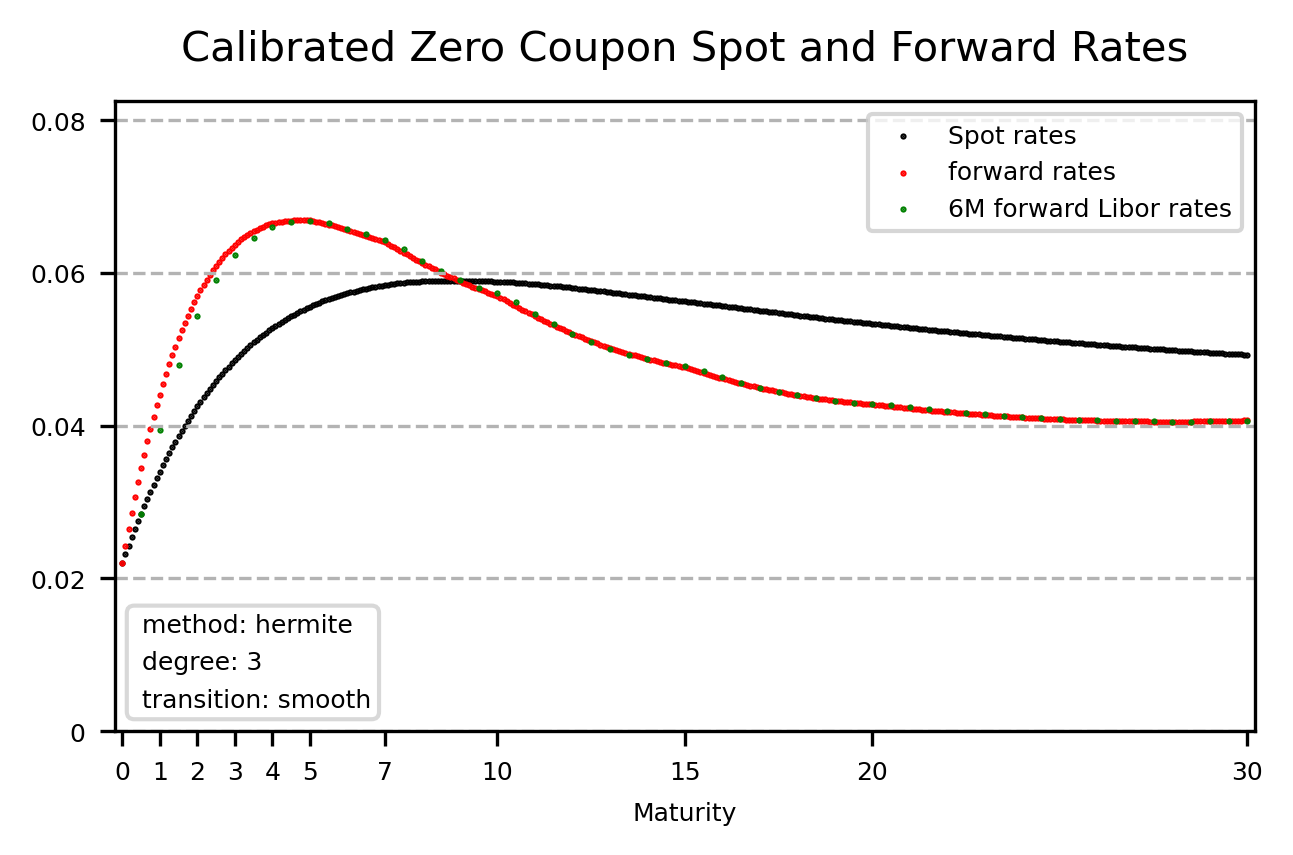

In [51]:
# PLot of the fitted ZCB term structures of spot and forward rates
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated Zero Coupon Spot and Forward Rates", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter[0:], R_inter[0:], s = 1, color = 'black', marker = ".",label="Spot rates")
p2 = ax.scatter(T_inter[0:], f_inter[0:], s = 1, color = 'red', marker = ".",label="forward rates")
p3 = ax.scatter(T_6M, L_6M, s = 1, color = 'green', marker = ".",label="6M forward Libor rates")
plots = [p1,p2,p3]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
if interpolation_options["method"] == "hermite":
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n degree: {interpolation_options['degree']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
else:
    ax.text(0.32,0.0032,f" method: {interpolation_options['method']} \n transition: {interpolation_options['transition']}", fontsize = 6,linespacing = 1.7, bbox = bbox)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()


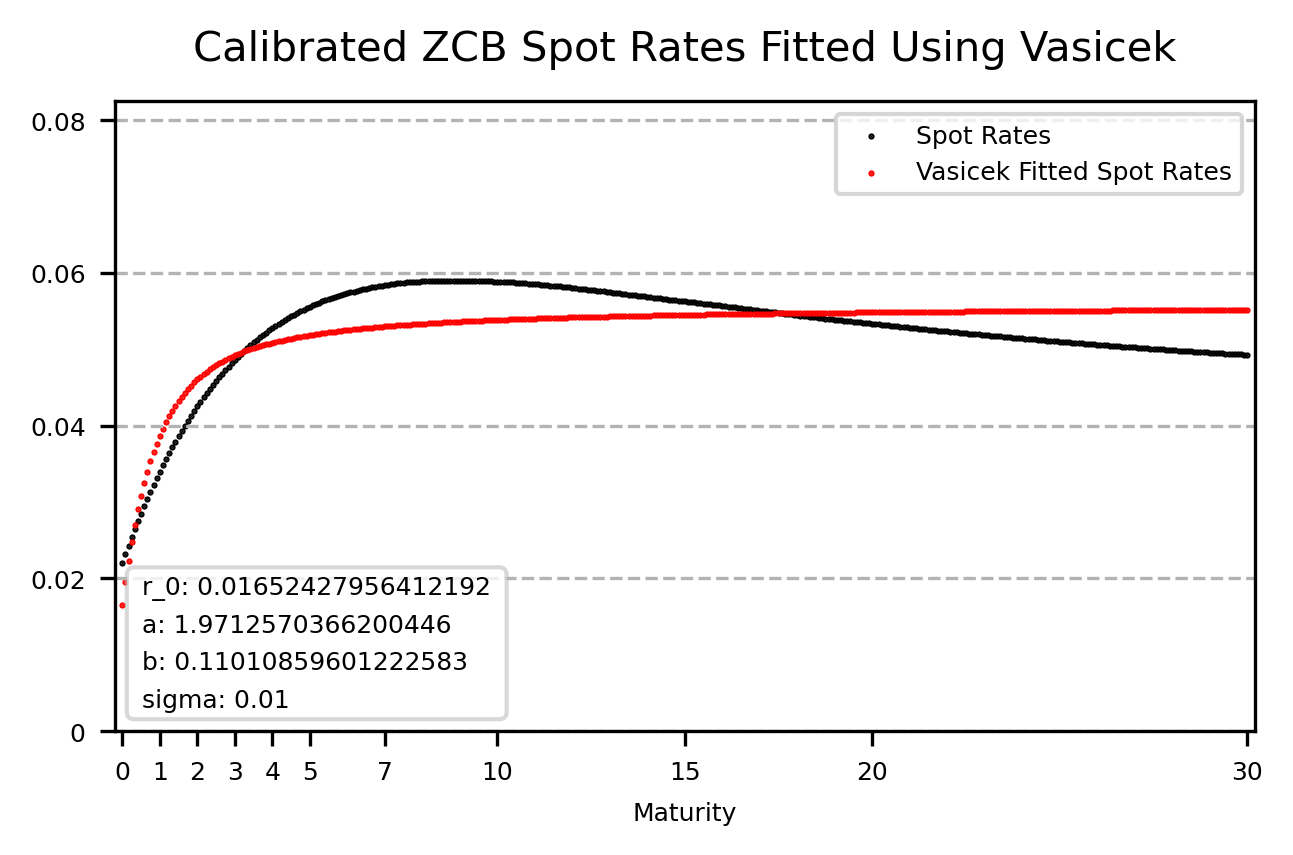

In [52]:

# Plot of Calibrated ZCB Spot Rates Fitted Using Vasicek
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Calibrated ZCB Spot Rates Fitted Using Vasicek", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([0,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_inter, R_inter, s = 1, color = 'black', marker = ".",label="Spot Rates")
p2 = ax.scatter(T_inter, R_vasicek, s = 1, color = 'red', marker = ".",label="Vasicek Fitted Spot Rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)
bbox = {"facecolor": (1,1,1,0.8),"edgecolor": (0.7,0.7,0.7,0.5),"boxstyle": "Round"}
ax.text(0.32,0.0032,f" r_0: {r0_vasicek} \n a: {a_vasicek} \n b: {b_vasicek} \n sigma: {sigma_vasicek}", fontsize = 6,linespacing = 1.7, bbox = bbox)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()


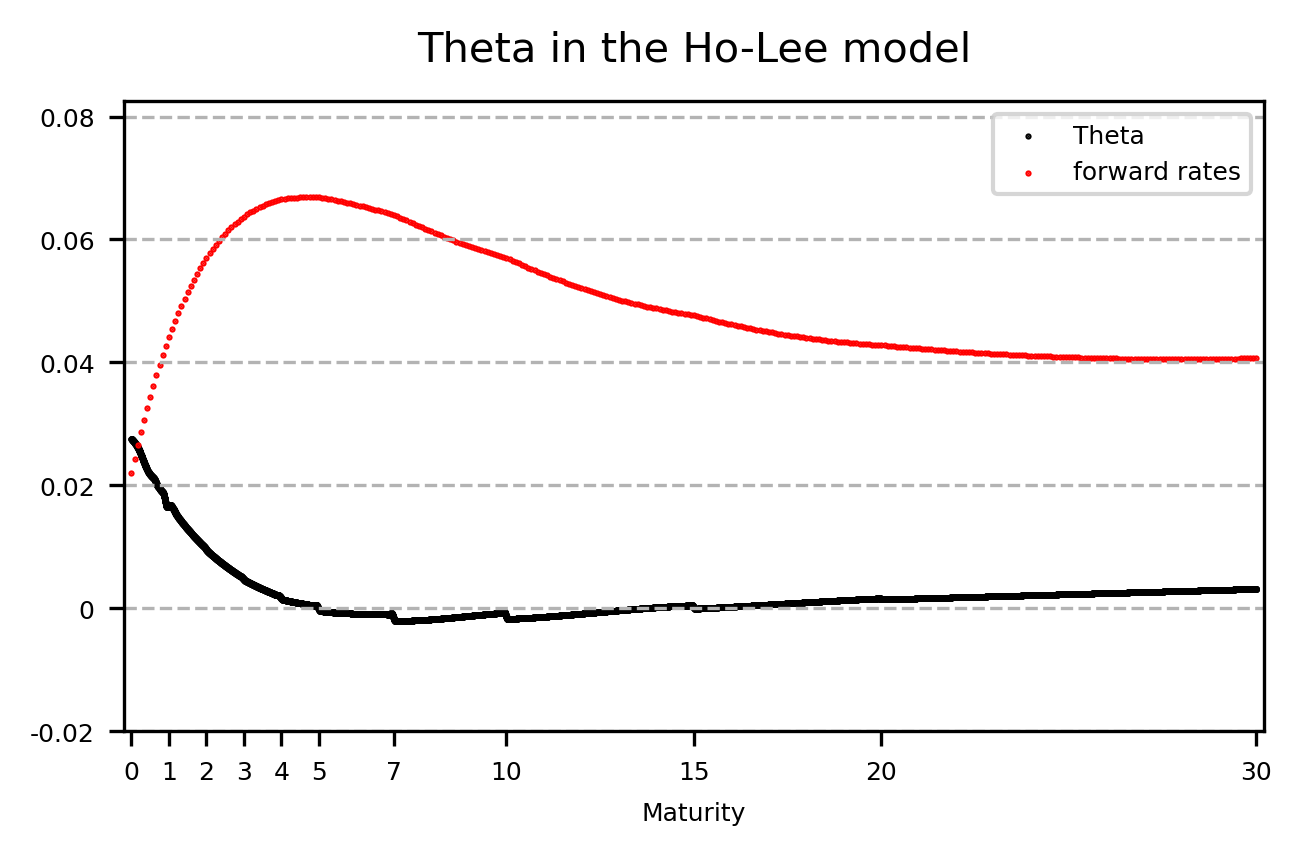

In [53]:

# Plot of Theta(t) in the HO-Lee model
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Theta in the Ho-Lee model", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,1,2,3,4,5,7,10,15,20,30]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]+-0.2,xticks[-1]+0.2])
plt.xlabel(f"Maturity",fontsize = 6)
ax.set_yticks([-0.02,0,0.02,0.04,0.06,0.08])
ax.set_yticklabels([-0.02,0,0.02,0.04,0.06,0.08],fontsize = 6)
ax.set_ylim([-0.02,0.0825])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(T_star, theta, s = 1, color = 'black', marker = ".",label="Theta")
p2 = ax.scatter(T_inter[0:], f_inter[0:], s = 1, color = 'red', marker = ".",label="forward rates")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 6)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()


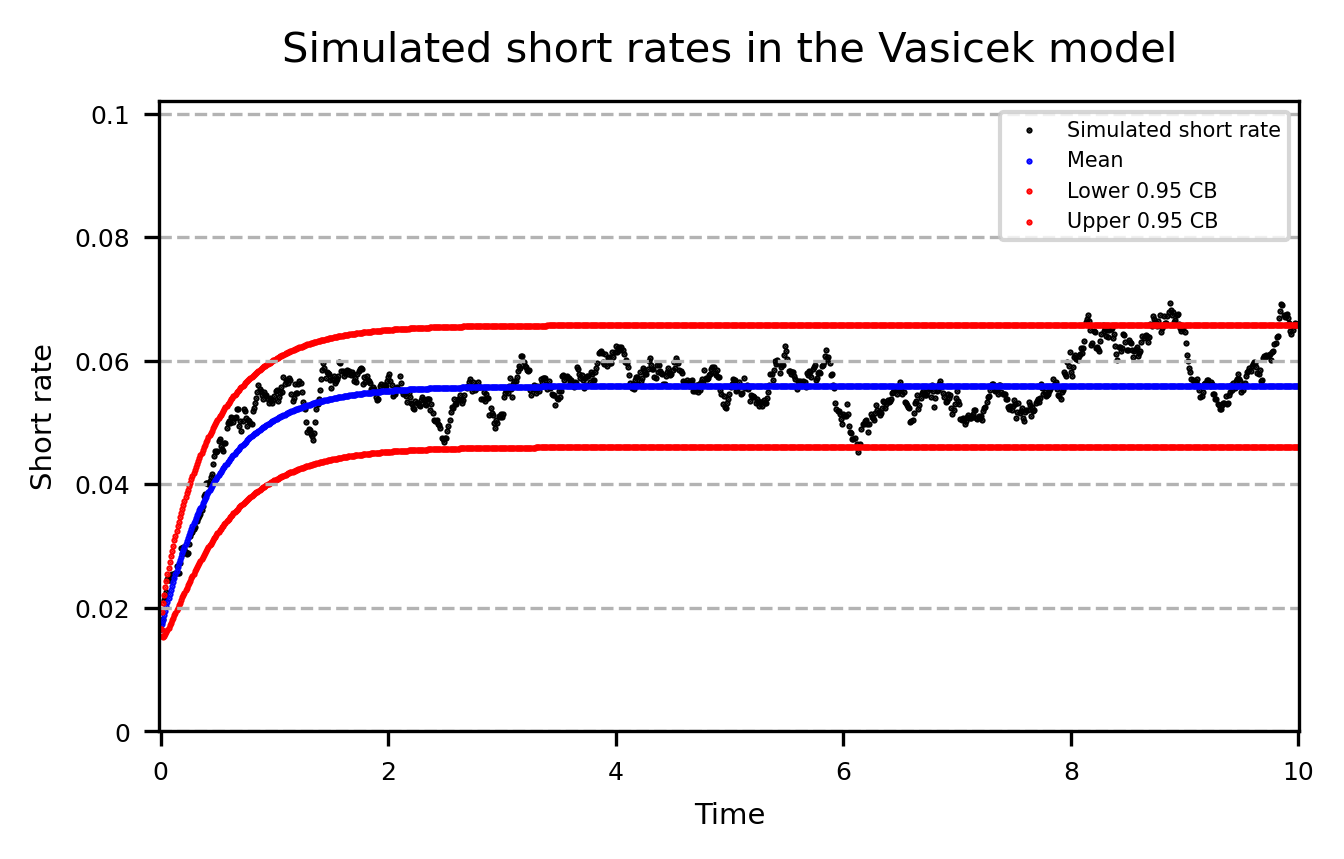

In [54]:

# PLot of simulated short rates in the Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated short rates in the Vasicek model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_vasicek, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, mean_vasicek, s = 1, color = 'blue', marker = ".",label=f"Mean")
p3 = ax.scatter(t_simul, lb_vasicek, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p4 = ax.scatter(t_simul, ub_vasicek, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()


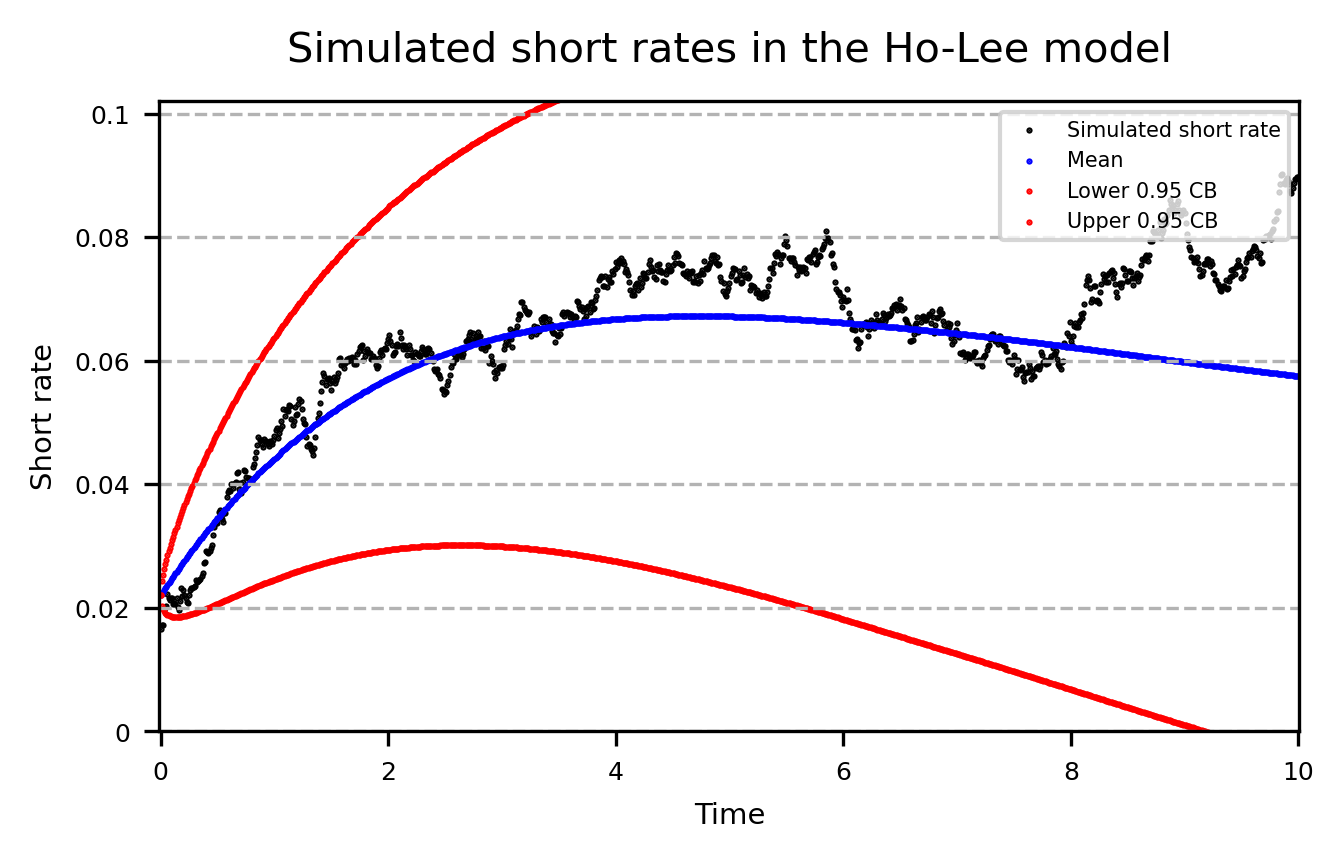

In [55]:
# PLot of simulated short rates in the Vasicek model
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated short rates in the Ho-Lee model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Time",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_ho_lee, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, mean_ho_lee, s = 1, color = 'blue', marker = ".",label=f"Mean")
p3 = ax.scatter(t_simul, lb_ho_lee, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p4 = ax.scatter(t_simul, ub_ho_lee, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()


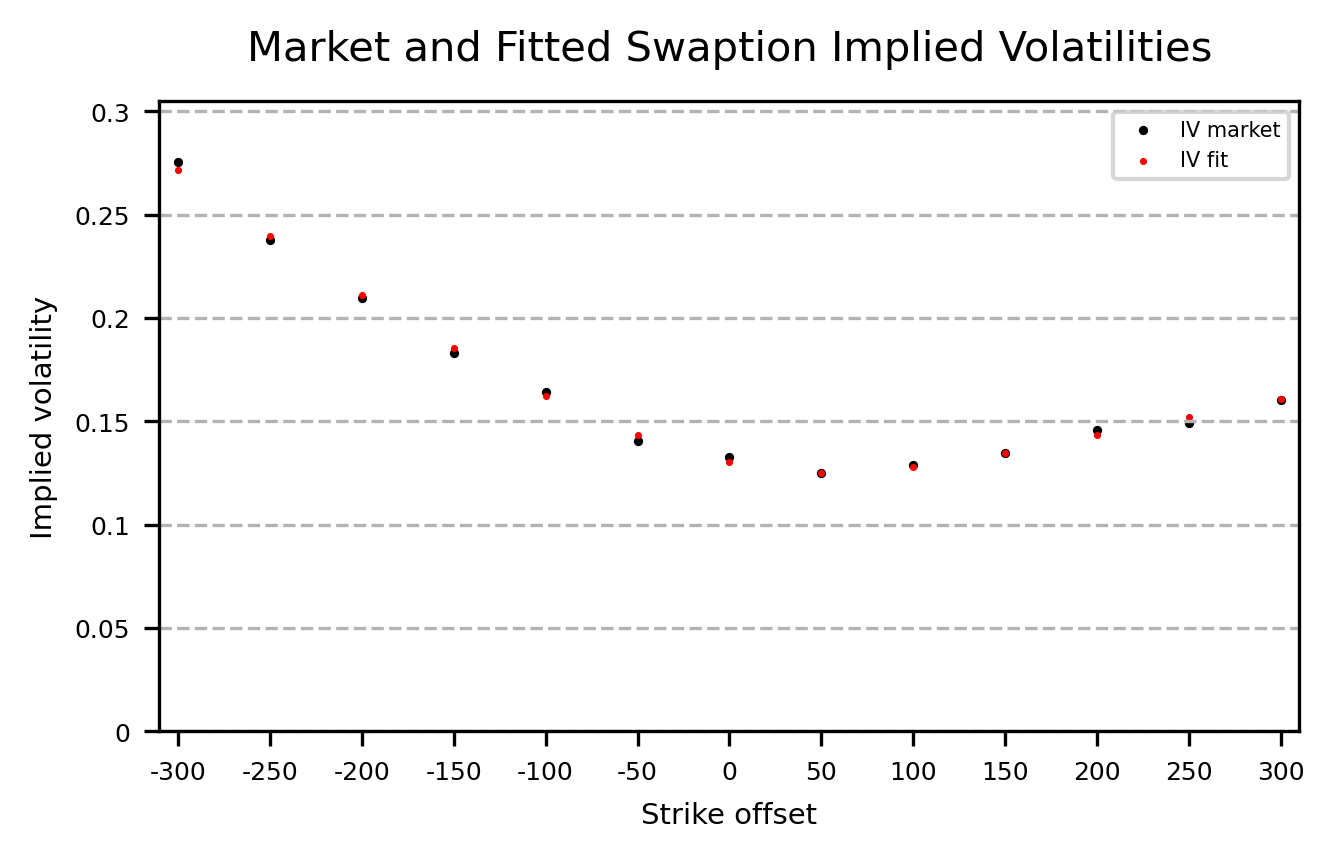

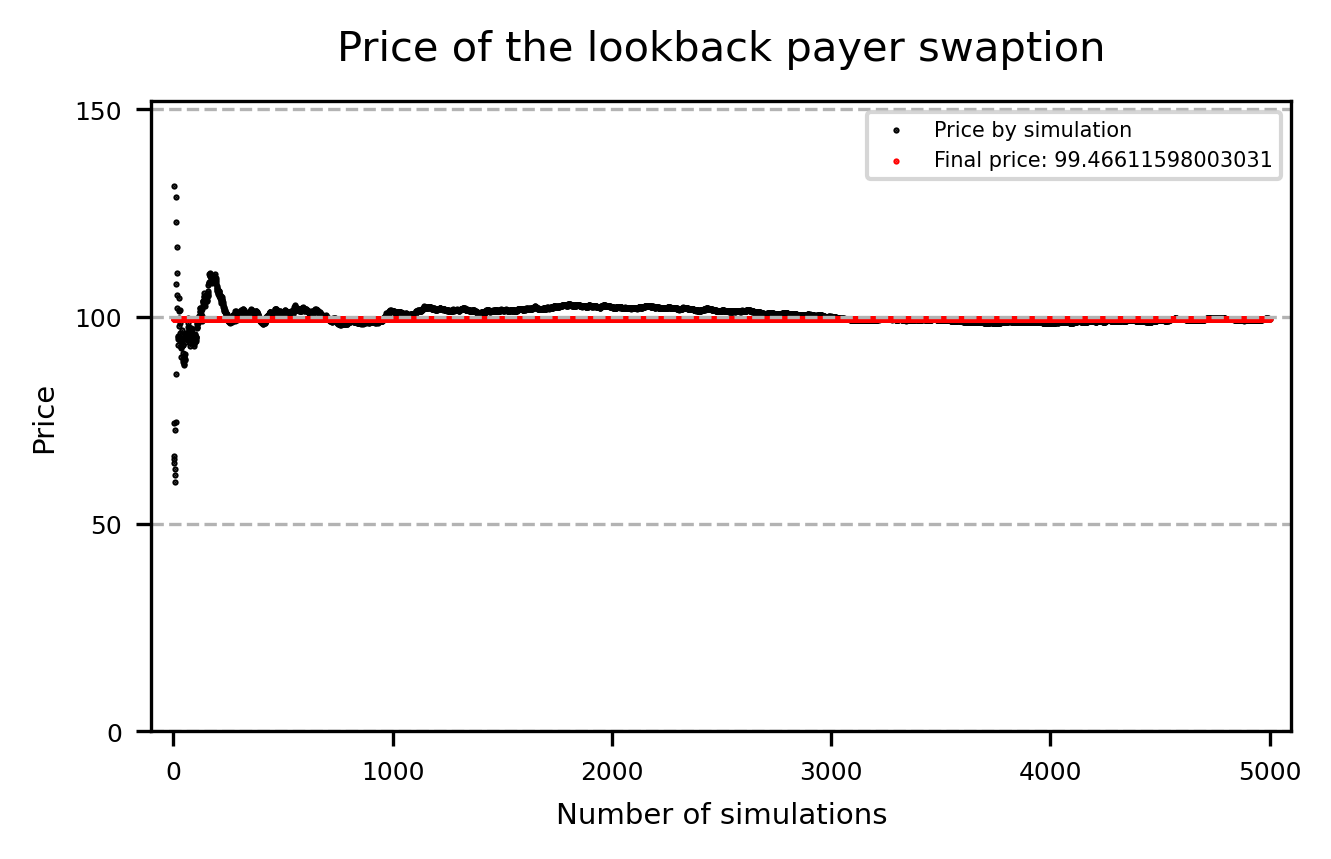

In [56]:

# Plot of swaption market implied volatilities
fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Market and Fitted Swaption Implied Volatilities", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = K_swaption_offset
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-10,xticks[-1]+10])
plt.xlabel(f"Strike offset",fontsize = 7)
ax.set_yticks([0,0.05,0.1,0.15,0.2,0.25,0.3])
ax.set_yticklabels([0,0.05,0.1,0.15,0.2,0.25,0.3],fontsize = 6)
ax.set_ylim([0,0.305])
ax.set_ylabel(f"Implied volatility",fontsize = 7)
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
p1 = ax.scatter(K_swaption_offset, iv_swaption_market, s = 6, color = 'black', marker = ".",label="IV market")
p2 = ax.scatter(K_swaption_offset, iv_fit, s = 2, color = 'red', marker = ".",label="IV fit")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()

fig = plt.figure(constrained_layout=False, dpi = 300, figsize = (5,3))
fig.suptitle(f"Price of the lookback payer swaption", fontsize = 10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,int((1/5)*N_simul_lookback),int((2/5)*N_simul_lookback),int((3/5)*N_simul_lookback),int((4/5)*N_simul_lookback),N_simul_lookback]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-int(N_simul_lookback/50),xticks[-1]+int(N_simul_lookback/50)])
plt.xlabel(f"Number of simulations",fontsize = 7)
ax.set_yticks([0,50,100,150])
ax.set_yticklabels([0,50,100,150],fontsize = 6)
ax.set_ylim([0,152])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Price",fontsize = 7)
p1 = ax.scatter(np.array([i for i in range(1,N_simul_lookback+1)]), price_lookback, s = 1, color = 'black', marker = ".",label="Price by simulation")
p2 = ax.scatter(np.array([i for i in range(1,N_simul_lookback+1)]), np.ones(N_simul_lookback)*price_lookback[-1], s = 1, color = 'red', marker = ".",label=f"Final price: {price_lookback[-1]}")
plots = [p1,p2]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
#REMEMBER TO CHANGE: fig.savefig("/Users/PC/Documents/Dokumenter – Olivia's Macbook/9. Semester/Fixed Income/FixedIncomeCO/PLOTS/1a_zcb_term_structure.pdf")
plt.show()
